# 映画レビューのテキスト分類

https://www.tensorflow.org/tutorials/keras/text_classification?hl=ja

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


In [17]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## データの観察
データ形式の理解のために、ロードしたデータの中身を観察する。

このデータセットは前処理済みで、サンプルそれぞれが映画レビューの中の単語を表す整数の配列になっている。

In [18]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

# データは整数配列になっており、サンプルごとに長さが異なる
print(train_data[0])
print((len(train_data[0]), len(train_data[1])))

Training entries: 25000, labels: 25000
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
(218, 189)


## 整数を単語に戻してみる
整数を文字列にマッピングする辞書オブジェクトを検索するためのヘルパー関数を定義する。

In [19]:
# 単語を整数にマッピングする辞書
word_index = imdb.get_word_index()

# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return " ".join([reverse_word_index.get(i, '?') for i in text])

In [20]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## データの準備

レビューデータはニューラルネットワークに投入する前に、テンソルに変換する必要がある。  
この変換には2つの方法がある。

- 配列をワンホットエンコーディングと同じように、単語の出現を表す0と1のベクトルに変換する。例えば[3, 5]という配列は、インデックス3と5を除いてすべて0の10000次元のベクトルになる。これをネットワークの最初の層、すなわち、浮動小数点のベクトルデータを扱うことができるDense層とする。
- 配列をパディングによって同じ長さに揃え、`サンプル数 * 長さの最大値`の形の整数テンソルにする。この場合、この形式を扱うことができるEmbedding層をネットワークの最初の層にする。

今回のチュートリアルでは、後者を採用する。

In [22]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [23]:
# データは固定長の整数配列になっている
print(train_data[0])
print((len(train_data[0]), len(train_data[1])))

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## モデルの構築

In [24]:
# 入力の形式は映画レビューで使われている語彙数(10000語)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## 損失関数とオプティマイザ

In [26]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## 検証用データを作る

訓練を行う際、モデルが見ていないデータでの正解率を検証する。
もとの訓練用データから10000個のサンプルを検証用データ(validation set)とする。

In [27]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## モデルの訓練

In [29]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 95us/sample - loss: 0.6918 - accuracy: 0.5406 - val_loss: 0.6898 - val_accuracy: 0.5196
Epoch 2/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.6858 - accuracy: 0.5767 - val_loss: 0.6821 - val_accuracy: 0.6249
Epoch 3/40
15000/15000 [==============================] - 1s 42us/sample - loss: 0.6741 - accuracy: 0.6776 - val_loss: 0.6683 - val_accuracy: 0.6789
Epoch 4/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.6548 - accuracy: 0.7277 - val_loss: 0.6469 - val_accuracy: 0.7316
Epoch 5/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.6271 - accuracy: 0.7667 - val_loss: 0.6180 - val_accuracy: 0.7739
Epoch 6/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.5920 - accuracy: 0.7985 - val_loss: 0.5833 - val_accuracy: 0.7928
Epoch 7/40
15000/15000 [==============================] 

## モデルの評価

In [31]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/25000 - 1s - loss: 0.3219 - accuracy: 0.8740
[0.3218651687288284, 0.874]


## 正解率と損失の時系列グラフを描く

`model.fit()`は訓練中に発生したすべてのことを記録した辞書を含む`History`オブジェクトを返す。

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

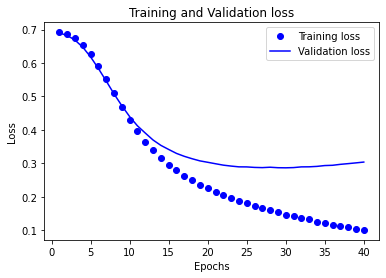

In [37]:
import matplotlib.pyplot as plt
# 値の取得
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo"は青の点を意味する
plt.plot(epochs, loss, "bo", label="Training loss")
# "b"は青の実線を意味する
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

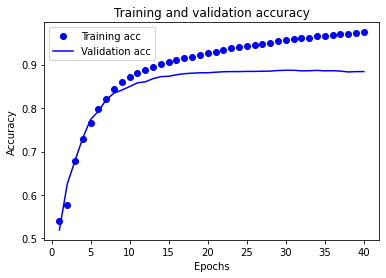

In [39]:
# 図のクリア
plt.clf()

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## 結果グラフの見方

損失のグラフ、正解率のグラフのいずれについても、20Epoch過ぎたあたりからTrainingのグラフがそのまま伸びている一方で、Validationの結果が底打ち/頭打ちになっている。
Validationには学習に使用していないデータ(モデルにとって未知のデータ)が使用されており、20epochあたりからは学習が進んでも学習データに対する最適化が進んでいるだけで、未知データに対する(正しい)表現力はもはや獲得できていないことを意味している。「過学習」の一例。